# US Stock Portfolio Analysis

해외주식 포트폴리오 분석 노트북

이 노트북은 다음 분석을 제공합니다:
1. 오늘 매도한 종목 분석
2. 포트폴리오 보유 비중 파이 차트
3. 보유 종목별 수익률/홀딩기간 막대 차트
4. 포트폴리오 vs S&P500/NASDAQ 수익률 비교 (TWR/MWR)
5. 요약 테이블

In [97]:
import sys
import warnings
from pathlib import Path

# Suppress pandas SQLAlchemy warning (pymysql works fine)
warnings.filterwarnings('ignore', message='.*pandas only supports SQLAlchemy.*')

# Add project root to path
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import date, timedelta
from decimal import Decimal

from db.connection import get_connection

# Set Korean font for matplotlib (if available)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    pass
plt.rcParams['axes.unicode_minus'] = False

# Get database connection
conn = get_connection()
print(f"Connected to database. Today: {date.today()}")

Connected to database. Today: 2026-02-05


## 1. 오늘 매도한 종목 (Sold Stocks Today)

오늘 매도한 종목들의 실현 수익률과 보유 기간을 분석합니다.

In [98]:
today = date.today()

# Query sold stocks today
sold_query = """
SELECT 
    stock_code,
    stock_name,
    currency,
    trade_date as buy_date,
    closed_date as sell_date,
    net_quantity as quantity,
    avg_purchase_price as buy_price,
    current_price as sell_price,
    total_cost,
    realized_pnl,
    holding_days,
    CASE WHEN total_cost > 0 
         THEN (realized_pnl / total_cost) * 100 
         ELSE 0 END as realized_return_pct
FROM daily_lots
WHERE is_closed = TRUE AND closed_date = %s
ORDER BY realized_pnl DESC
"""

sold_df = pd.read_sql(sold_query, conn, params=(today,))

if sold_df.empty:
    print(f"오늘({today}) 매도한 종목이 없습니다.")
else:
    print(f"오늘 매도한 종목: {len(sold_df)}개")
    print()
    
    # Display sold stocks
    display_df = sold_df[['stock_code', 'stock_name', 'quantity', 'buy_price', 'sell_price', 
                         'realized_pnl', 'realized_return_pct', 'holding_days']].copy()
    display_df.columns = ['종목코드', '종목명', '수량', '매수가(USD)', '매도가(USD)', 
                         '실현손익(USD)', '수익률(%)', '보유일']
    display_df['매수가(USD)'] = display_df['매수가(USD)'].apply(lambda x: f"${x:,.2f}")
    display_df['매도가(USD)'] = display_df['매도가(USD)'].apply(lambda x: f"${x:,.2f}")
    display_df['실현손익(USD)'] = display_df['실현손익(USD)'].apply(lambda x: f"${x:+,.2f}")
    display_df['수익률(%)'] = display_df['수익률(%)'].apply(lambda x: f"{x:+.2f}%")
    display(display_df)
    
    # Summary
    total_pnl = sold_df['realized_pnl'].sum()
    avg_return = sold_df['realized_return_pct'].mean()
    avg_holding = sold_df['holding_days'].mean()
    print(f"\n총 실현손익: ${total_pnl:+,.2f}")
    print(f"평균 수익률: {avg_return:+.2f}%")
    print(f"평균 보유일: {avg_holding:.1f}일")

오늘(2026-02-05) 매도한 종목이 없습니다.


## 2. 포트폴리오 보유 비중 (Portfolio Weight Pie Chart)

Snapshot date (기준일): 2026-02-04
오늘(2026-02-04) 매수 종목: {'LITE', 'MRK', 'GEV', 'BE', 'DE', 'COHR', 'TEVA'}
전일 보유 종목 (어제 이전 매수): {'LITE', 'GLW', 'MRK', 'GEV', 'BE', 'DE', 'AAOI', 'COHR', 'TEVA'}

[외화잔고 계산]
  외화주문가능금액: $2,519.51
  주식평가액: $11,204.97
  총 자산 (외화잔고): $13,724.48

총 포트폴리오 가치: $13,724.48
보유 종목: 9개 (신규진입: 0개, 추가매수: 7개)



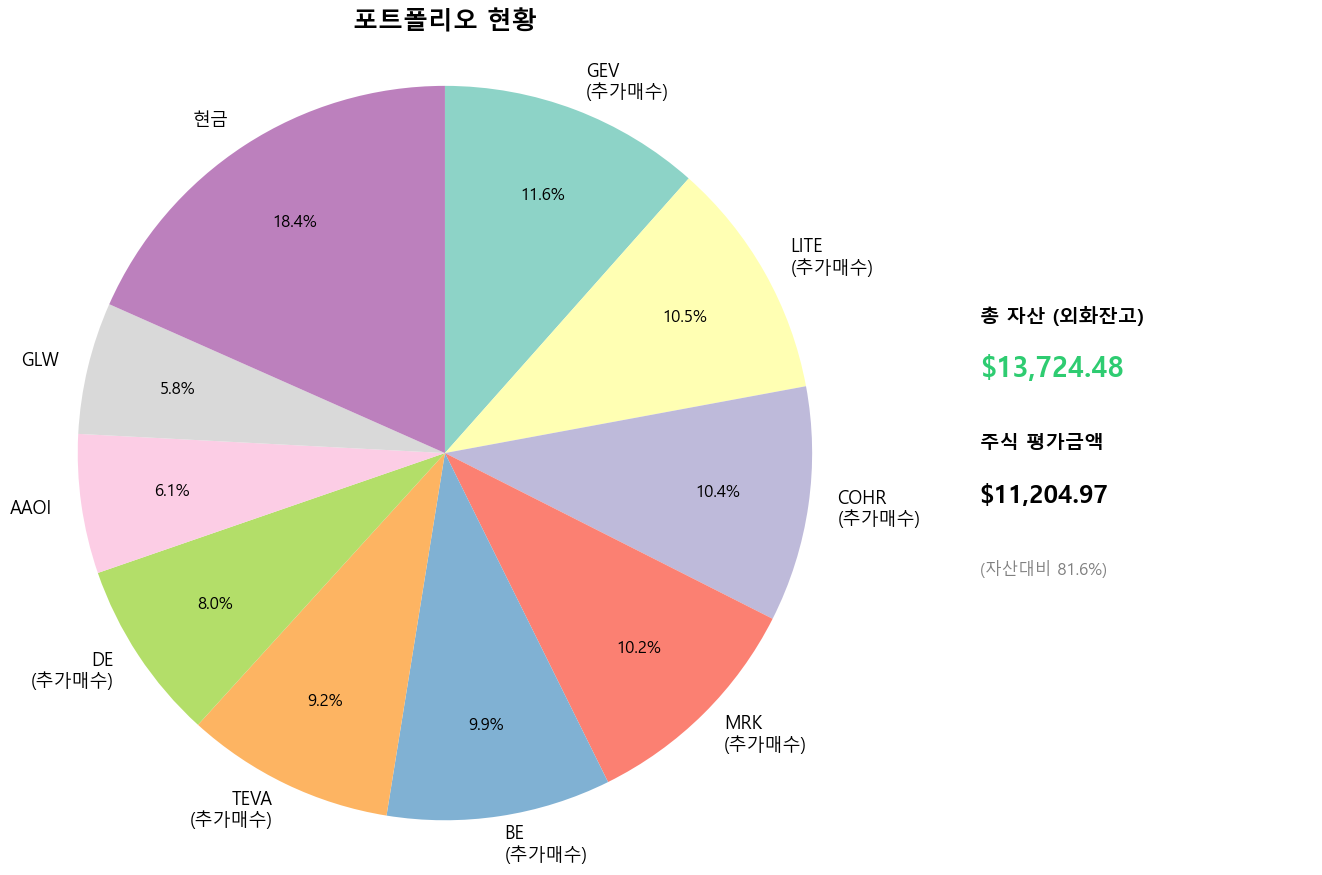

In [99]:
# Query current portfolio composition with today's buy info
# Get the latest dates
with conn.cursor() as cur:
    cur.execute("SELECT MAX(snapshot_date) FROM portfolio_snapshot")
    snapshot_date = cur.fetchone()[0]

    print(f"Snapshot date (기준일): {snapshot_date}")

# 오늘 매수한 종목 확인 (snapshot_date 기준으로!)
today_buys_query = """
SELECT DISTINCT stk_cd
FROM account_trade_history
WHERE trade_date = %s AND io_tp_nm LIKE '%%매수%%'
"""

# 전일 보유 종목 (daily_lots에서 trade_date < 오늘인 종목 = 어제 이전에 산 것)
prev_holdings_query = """
SELECT DISTINCT stock_code
FROM daily_lots
WHERE is_closed = FALSE AND trade_date < %s
"""

portfolio_query = """
SELECT
    ps.stock_code,
    ps.stock_name,
    ps.market_value,
    ps.portfolio_weight_pct,
    ps.unrealized_return_pct,
    ps.total_portfolio_value
FROM portfolio_snapshot ps
WHERE ps.snapshot_date = %s
ORDER BY ps.portfolio_weight_pct DESC
"""

# Execute queries - snapshot_date 기준으로 오늘 매수 확인
today_buys_df = pd.read_sql(today_buys_query, conn, params=(snapshot_date,))
today_buy_symbols = set(today_buys_df['stk_cd'].tolist())

prev_holdings_df = pd.read_sql(prev_holdings_query, conn, params=(snapshot_date,))
prev_holding_symbols = set(prev_holdings_df['stock_code'].tolist())

portfolio_df = pd.read_sql(portfolio_query, conn, params=(snapshot_date,))

print(f"오늘({snapshot_date}) 매수 종목: {today_buy_symbols if today_buy_symbols else '없음 (동기화 필요)'}")
print(f"전일 보유 종목 (어제 이전 매수): {prev_holding_symbols}")

if portfolio_df.empty:
    print("포트폴리오 스냅샷 데이터가 없습니다.")
else:
    # 총 자산 계산: 외화주문가능금액 + 주식평가액 (외화잔고 개념)
    # 1. 외화주문가능금액 from API
    try:
        from services.kis_service import KISAPIClient
        import requests
        
        client = KISAPIClient()
        url = f"{client.base_url}/uapi/overseas-stock/v1/trading/inquire-psamount"
        headers = client._get_headers("TTTS3007R")
        params = {
            "CANO": client.cano,
            "ACNT_PRDT_CD": client.acnt_prdt_cd,
            "OVRS_EXCG_CD": "NASD",
            "OVRS_ORD_UNPR": "100",
            "ITEM_CD": "AAPL",
        }
        client._wait_for_rate_limit()
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        output = data.get("output", {})
        cash_available = float(output.get("ord_psbl_frcr_amt", 0) or 0)
    except Exception as e:
        print(f"[WARN] API 현금조회 실패: {e}")
        cash_available = 0
    
    # 2. 주식평가액 from holdings
    with conn.cursor() as cur:
        cur.execute("""
            SELECT COALESCE(SUM(evlt_amt), 0)
            FROM holdings
            WHERE snapshot_date = (SELECT MAX(snapshot_date) FROM holdings)
        """)
        stock_value = float(cur.fetchone()[0] or 0)
    
    # 총 자산 = 외화주문가능금액 + 주식평가액
    total_value = cash_available + stock_value
    total_stock_value = portfolio_df['market_value'].sum()
    stock_exposure_pct = (total_stock_value / total_value * 100) if total_value > 0 else 0

    print(f"\n[외화잔고 계산]")
    print(f"  외화주문가능금액: ${cash_available:,.2f}")
    print(f"  주식평가액: ${stock_value:,.2f}")
    print(f"  총 자산 (외화잔고): ${total_value:,.2f}")

    # 라벨 결정: 신규진입 / 추가매수 / 없음
    def get_label(row):
        symbol = row['stock_code'].upper()
        is_today_buy = symbol in today_buy_symbols
        was_prev_held = symbol in prev_holding_symbols

        if is_today_buy and was_prev_held:
            return f"{symbol}\n(추가매수)"
        elif is_today_buy and not was_prev_held:
            return f"{symbol}\n(신규진입)"
        else:
            return symbol

    portfolio_df["display_name"] = portfolio_df.apply(get_label, axis=1)

    new_buy_count = sum(1 for s in portfolio_df['stock_code'] if s in today_buy_symbols and s not in prev_holding_symbols)
    add_buy_count = sum(1 for s in portfolio_df['stock_code'] if s in today_buy_symbols and s in prev_holding_symbols)

    print(f"\n총 포트폴리오 가치: ${total_value:,.2f}")
    print(f"보유 종목: {len(portfolio_df)}개 (신규진입: {new_buy_count}개, 추가매수: {add_buy_count}개)")
    print()

    # Recalculate weight based on correct total_value
    portfolio_df['weight_pct'] = (portfolio_df['market_value'] / total_value * 100) if total_value > 0 else 0

    # Pie chart with right text panel (like asset project)
    fig = plt.figure(figsize=(14, 9))
    ax_pie = fig.add_axes([0.02, 0.05, 0.68, 0.85])  # 파이 차트 영역
    ax_text = fig.add_axes([0.70, 0.30, 0.28, 0.40])  # 우측 텍스트 영역

    # Group small positions as 'Others'
    threshold = 3.0  # 3% 미만은 기타로 묶음
    main_positions = portfolio_df[portfolio_df['weight_pct'] >= threshold]
    others = portfolio_df[portfolio_df['weight_pct'] < threshold]

    labels = list(main_positions['display_name'])
    sizes = list(main_positions['weight_pct'])

    # 현금 비중 추가
    cash_weight = (cash_available / total_value * 100) if total_value > 0 else 0
    if cash_weight >= threshold:
        labels.append('현금')
        sizes.append(cash_weight)

    if not others.empty:
        labels.append('기타')
        sizes.append(others['weight_pct'].sum())

    # Colors
    colors = plt.cm.Set3(range(len(labels)))

    wedges, texts, autotexts = ax_pie.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        counterclock=False,
        radius=1.2,
        labeldistance=1.08,
        pctdistance=0.75
    )

    # 폰트 크기 증가
    for t in texts:
        t.set_fontsize(13)  # 티커 폰트 크기 증가
    for t in autotexts:
        t.set_fontsize(12)  # 비중 폰트 크기 증가

    ax_pie.set_title('포트폴리오 현황', fontsize=18, fontweight='bold', pad=30)

    # 우측 텍스트 패널
    ax_text.axis("off")
    ax_text.text(0.15, 0.80, "총 자산 (외화잔고)", fontsize=14, fontweight="bold")
    ax_text.text(0.15, 0.65, f"${total_value:,.2f}", fontsize=20, fontweight="bold", color="#2ecc71")
    ax_text.text(0.15, 0.45, "주식 평가금액", fontsize=14, fontweight="bold")
    ax_text.text(0.15, 0.30, f"${total_stock_value:,.2f}", fontsize=18, fontweight="bold")
    ax_text.text(0.15, 0.10, f"(자산대비 {stock_exposure_pct:.1f}%)", fontsize=12, color="gray")

    plt.show()

## 3. 보유 종목별 수익률/홀딩기간 (Holdings Analysis Bar Chart)

Snapshot date (기준일): 2026-02-04
오늘(2026-02-04) 매수 종목: {'LITE', 'MRK', 'GEV', 'BE', 'DE', 'COHR', 'TEVA'}
전일 보유 종목 (어제 이전 매수): {'LITE', 'GLW', 'MRK', 'GEV', 'BE', 'DE', 'AAOI', 'COHR', 'TEVA'}

보유 종목: 9개 (신규진입: 0개, 추가매수: 7개)



,종목코드,종목명,수량,평균단가,현재가,미실현손익,수익률(%),평균보유일
0,LITE,루멘텀 홀딩스,3.0,$462.19,$481.87,$+59.05,+4.26%,0
1,GEV,GE베르노바,2.0,$778.75,$792.81,$+28.12,+1.81%,0
2,AAOI,어플라이드 옵토일렉트로닉스,18.0,$46.00,$46.70,$+12.65,+1.53%,1
3,COHR,코히어런트,6.0,$233.65,$237.12,$+20.82,+1.49%,0
4,TEVA,테바 파머슈티컬 인더스트리스(ADR),35.0,$35.84,$36.06,$+7.85,+0.63%,0
5,DE,디어,2.0,$543.94,$546.80,$+5.72,+0.53%,0
6,BE,블룸 에너지,8.0,$168.66,$169.31,$+5.18,+0.38%,0
7,MRK,머크,12.0,$116.70,$116.90,$+2.40,+0.17%,0
8,GLW,코닝,7.0,$117.38,$113.91,$-24.29,-2.96%,1


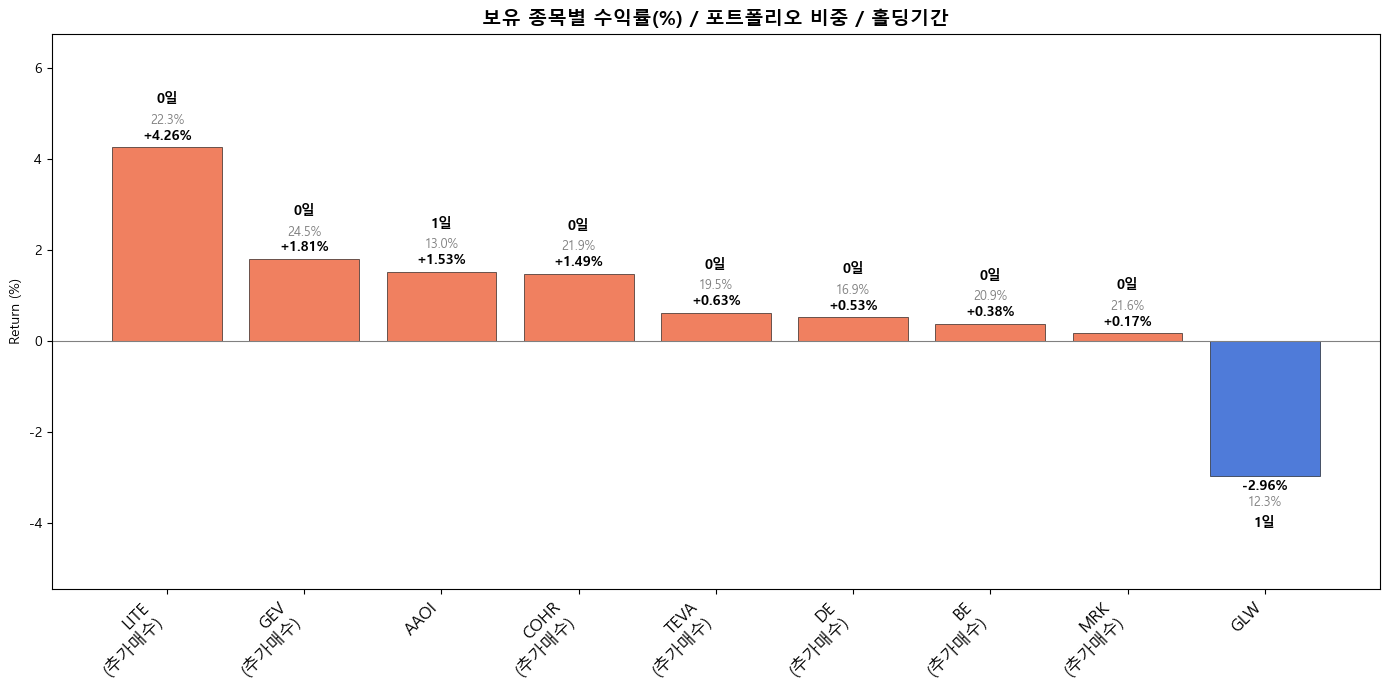

In [100]:
# Query current holdings with lot details
with conn.cursor() as cur:
    cur.execute("SELECT MAX(snapshot_date) FROM portfolio_snapshot")
    snapshot_date = cur.fetchone()[0]
    print(f"Snapshot date (기준일): {snapshot_date}")

# 오늘 매수한 종목 확인 (snapshot_date 기준으로!)
today_buys_query = """
SELECT DISTINCT stk_cd
FROM account_trade_history
WHERE trade_date = %s AND io_tp_nm LIKE '%%매수%%'
"""

# 전일 보유 종목 (daily_lots에서 trade_date < 오늘인 종목 = 어제 이전에 산 것)
prev_holdings_query = """
SELECT DISTINCT stock_code
FROM daily_lots
WHERE is_closed = FALSE AND trade_date < %s
"""

holdings_query = """
SELECT
    dl.stock_code,
    dl.stock_name,
    SUM(dl.net_quantity) as total_qty,
    SUM(dl.total_cost) / SUM(dl.net_quantity) as avg_cost,
    MAX(dl.current_price) as current_price,
    SUM(dl.unrealized_pnl) as unrealized_pnl,
    CASE WHEN SUM(dl.total_cost) > 0
         THEN (SUM(dl.unrealized_pnl) / SUM(dl.total_cost)) * 100
         ELSE 0 END as return_pct,
    AVG(dl.holding_days) as avg_holding_days,
    MIN(dl.trade_date) as first_buy_date,
    COALESCE(MAX(ps.portfolio_weight_pct), 0) as weight_pct
FROM daily_lots dl
LEFT JOIN portfolio_snapshot ps ON dl.stock_code = ps.stock_code
    AND ps.snapshot_date = (SELECT MAX(snapshot_date) FROM portfolio_snapshot)
WHERE dl.is_closed = FALSE
GROUP BY dl.stock_code, dl.stock_name
ORDER BY return_pct DESC
"""

# Execute queries - snapshot_date 기준으로 오늘 매수 확인
today_buys_df = pd.read_sql(today_buys_query, conn, params=(snapshot_date,))
today_buy_symbols = set(today_buys_df['stk_cd'].tolist())

prev_holdings_df = pd.read_sql(prev_holdings_query, conn, params=(snapshot_date,))
prev_holding_symbols = set(prev_holdings_df['stock_code'].tolist())

holdings_df = pd.read_sql(holdings_query, conn)

print(f"오늘({snapshot_date}) 매수 종목: {today_buy_symbols if today_buy_symbols else '없음 (동기화 필요)'}")
print(f"전일 보유 종목 (어제 이전 매수): {prev_holding_symbols}")

if holdings_df.empty:
    print("보유 종목이 없습니다.")
else:
    # 라벨 결정: 신규진입 / 추가매수 / 없음
    def get_label(row):
        symbol = row['stock_code'].upper()
        is_today_buy = symbol in today_buy_symbols
        was_prev_held = symbol in prev_holding_symbols

        if is_today_buy and was_prev_held:
            return f"{symbol}\n(추가매수)"
        elif is_today_buy and not was_prev_held:
            return f"{symbol}\n(신규진입)"
        else:
            return symbol

    holdings_df["display_name"] = holdings_df.apply(get_label, axis=1)

    new_buy_count = sum(1 for s in holdings_df['stock_code'] if s in today_buy_symbols and s not in prev_holding_symbols)
    add_buy_count = sum(1 for s in holdings_df['stock_code'] if s in today_buy_symbols and s in prev_holding_symbols)

    print(f"\n보유 종목: {len(holdings_df)}개 (신규진입: {new_buy_count}개, 추가매수: {add_buy_count}개)")
    print()

    # Display table
    display_holdings = holdings_df[['stock_code', 'stock_name', 'total_qty', 'avg_cost',
                                    'current_price', 'unrealized_pnl', 'return_pct', 'avg_holding_days']].copy()
    display_holdings.columns = ['종목코드', '종목명', '수량', '평균단가', '현재가', '미실현손익', '수익률(%)', '평균보유일']
    display_holdings['평균단가'] = display_holdings['평균단가'].apply(lambda x: f"${x:,.2f}")
    display_holdings['현재가'] = display_holdings['현재가'].apply(lambda x: f"${x:,.2f}")
    display_holdings['미실현손익'] = display_holdings['미실현손익'].apply(lambda x: f"${x:+,.2f}")
    display_holdings['수익률(%)'] = display_holdings['수익률(%)'].apply(lambda x: f"{x:+.2f}%")
    display_holdings['평균보유일'] = display_holdings['평균보유일'].apply(lambda x: f"{x:.0f}")
    display(display_holdings)

    # Single bar chart with holding days on top
    import numpy as np

    plot_df = holdings_df.copy()
    x = np.arange(len(plot_df))
    y = plot_df["return_pct"].astype(float).values
    weight = plot_df["weight_pct"].astype(float).values
    holding = plot_df["avg_holding_days"].fillna(0).astype(int).values
    names = plot_df["display_name"].astype(str).values

    fig, ax = plt.subplots(figsize=(max(14, len(plot_df) * 0.8), 7))

    colors = ["#f08060" if v >= 0 else "#4f7bd9" for v in y]
    bars = ax.bar(x, y, color=colors, edgecolor="black", linewidth=0.4)

    ax.axhline(0, color="gray", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right", fontsize=12)  # 폰트 크게
    ax.set_ylabel("Return (%)")
    ax.set_title("보유 종목별 수익률(%) / 포트폴리오 비중 / 홀딩기간", fontsize=14, fontweight='bold')

    ymax = max(y.max(), 0) if len(y) > 0 else 10
    ymin = min(y.min(), 0) if len(y) > 0 else -10
    pad = max((ymax - ymin) * 0.22, 2.5)  # 간격 줄임
    ax.set_ylim(ymin - pad, ymax + pad)

    OFFSET = 0.6  # 간격 더 줄임

    for bar, ret, w, days in zip(bars, y, weight, holding):
        cx = bar.get_x() + bar.get_width() / 2

        # 홀딩기간 (가장 위/아래)
        holding_y = ret + (OFFSET * 1.5 if ret >= 0 else -OFFSET * 1.5)
        ax.text(cx, holding_y, f"{days}일", ha="center",
                va="bottom" if ret >= 0 else "top", fontsize=10, color="black", fontweight="bold")

        # 비중 (중간)
        weight_y = ret + (OFFSET * 0.75 if ret >= 0 else -OFFSET * 0.75)
        ax.text(cx, weight_y, f"{w:.1f}%", ha="center",
                va="bottom" if ret >= 0 else "top", fontsize=9, color="gray")

        # 수익률 (막대 바로 위/아래)
        ret_y = ret + (0.1 if ret >= 0 else -0.1)
        ax.text(cx, ret_y, f"{ret:+.2f}%", ha="center",
                va="bottom" if ret >= 0 else "top", fontsize=10, color="black", fontweight="bold")

    plt.tight_layout()
    plt.show()

## 4. 포트폴리오 vs S&P500/NASDAQ 수익률 비교 (TWR/MWR)

In [101]:
def calculate_twr(daily_values: pd.Series) -> float:
    """
    Calculate Time-Weighted Return (TWR)
    TWR = Product of (1 + daily_return) - 1
    """
    if len(daily_values) < 2:
        return 0.0
    
    daily_returns = daily_values.pct_change().dropna()
    twr = ((1 + daily_returns).prod() - 1) * 100
    return twr

def calculate_mwr(cashflows: list, final_value: float, initial_value: float, periods: int) -> float:
    """
    Calculate Money-Weighted Return (MWR) using simplified IRR
    For simple approximation: MWR ≈ (Final - Initial - Net Cashflows) / Average Capital
    """
    if initial_value == 0 or periods == 0:
        return 0.0
    
    net_cashflows = sum(cf for cf, _ in cashflows)
    gain = final_value - initial_value - net_cashflows
    avg_capital = (initial_value + final_value) / 2
    
    if avg_capital == 0:
        return 0.0
    
    # Annualized return
    mwr = (gain / avg_capital) * (365 / periods) * 100 if periods > 0 else 0
    return mwr

In [102]:
# Get portfolio history and market index data
# Looking at the last 30 days
days_back = 30
start_date = date.today() - timedelta(days=days_back)

# Portfolio daily values
portfolio_hist_query = """
SELECT 
    snapshot_date,
    total_asset_usd as portfolio_value
FROM daily_portfolio_snapshot
WHERE snapshot_date >= %s
ORDER BY snapshot_date
"""

portfolio_hist = pd.read_sql(portfolio_hist_query, conn, params=(start_date,))

# Market index data
market_query = """
SELECT 
    index_date,
    sp500_close,
    nasdaq_close
FROM market_index
WHERE index_date >= %s
ORDER BY index_date
"""

market_hist = pd.read_sql(market_query, conn, params=(start_date,))

# Auto-sync market index if missing
if market_hist.empty:
    print(f"시장 지수 데이터가 없습니다. yfinance로 자동 동기화 중...")
    try:
        import sys
        sys.path.insert(0, str(PROJECT_ROOT))
        from services.market_index_service import sync_market_index
        
        sync_count = sync_market_index(conn, start_date=start_date, end_date=date.today())
        if sync_count > 0:
            # Re-query after sync
            market_hist = pd.read_sql(market_query, conn, params=(start_date,))
            print(f"동기화 완료: {sync_count}개 레코드")
        else:
            print("동기화 실패. yfinance 설치 확인: pip install yfinance")
    except Exception as e:
        print(f"시장 지수 동기화 실패: {e}")
        print("수동 실행: python -c \"from services.market_index_service import sync_market_index; from db.connection import get_connection; sync_market_index(get_connection())\"")

if portfolio_hist.empty:
    print(f"포트폴리오 히스토리 데이터가 없습니다. (기간: {start_date} ~ {date.today()})")
    print("daily_portfolio_snapshot 테이블을 확인하세요.")
elif market_hist.empty:
    print(f"시장 지수 데이터를 불러올 수 없습니다.")
else:
    # Merge data
    portfolio_hist['snapshot_date'] = pd.to_datetime(portfolio_hist['snapshot_date'])
    market_hist['index_date'] = pd.to_datetime(market_hist['index_date'])
    
    merged = portfolio_hist.merge(
        market_hist,
        left_on='snapshot_date',
        right_on='index_date',
        how='inner'
    )
    
    if merged.empty:
        print("포트폴리오와 시장 지수 데이터가 겹치지 않습니다.")
    else:
        # Calculate TWR
        portfolio_twr = calculate_twr(merged['portfolio_value'])
        sp500_twr = calculate_twr(merged['sp500_close'])
        nasdaq_twr = calculate_twr(merged['nasdaq_close'])
        
        print(f"=== 수익률 비교 (기간: {merged['snapshot_date'].min().date()} ~ {merged['snapshot_date'].max().date()}) ===")
        print(f"\nTWR (Time-Weighted Return):")
        print(f"  포트폴리오: {portfolio_twr:+.2f}%")
        print(f"  S&P 500:    {sp500_twr:+.2f}%")
        print(f"  NASDAQ:     {nasdaq_twr:+.2f}%")
        
        # Normalize for plotting (base 100)
        merged['portfolio_norm'] = (merged['portfolio_value'] / merged['portfolio_value'].iloc[0]) * 100
        merged['sp500_norm'] = (merged['sp500_close'] / merged['sp500_close'].iloc[0]) * 100
        merged['nasdaq_norm'] = (merged['nasdaq_close'] / merged['nasdaq_close'].iloc[0]) * 100
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.plot(merged['snapshot_date'], merged['portfolio_norm'], 
                label=f'Portfolio ({portfolio_twr:+.2f}%)', linewidth=2, color='blue')
        ax.plot(merged['snapshot_date'], merged['sp500_norm'], 
                label=f'S&P 500 ({sp500_twr:+.2f}%)', linewidth=1.5, linestyle='--', color='green')
        ax.plot(merged['snapshot_date'], merged['nasdaq_norm'], 
                label=f'NASDAQ ({nasdaq_twr:+.2f}%)', linewidth=1.5, linestyle='--', color='red')
        
        ax.axhline(y=100, color='gray', linewidth=0.5, linestyle=':')
        ax.set_xlabel('Date')
        ax.set_ylabel('Normalized Value (Base=100)')
        ax.set_title('Portfolio vs Market Indices (TWR)', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Alpha calculation
        alpha_vs_sp500 = portfolio_twr - sp500_twr
        alpha_vs_nasdaq = portfolio_twr - nasdaq_twr
        print(f"\nAlpha (초과수익률):")
        print(f"  vs S&P 500: {alpha_vs_sp500:+.2f}%p")
        print(f"  vs NASDAQ:  {alpha_vs_nasdaq:+.2f}%p")

포트폴리오와 시장 지수 데이터가 겹치지 않습니다.


## 5. 요약 테이블 (Summary Table)

In [103]:
# Get summary statistics
summary_query = """
SELECT
    (SELECT COUNT(DISTINCT stock_code) FROM daily_lots WHERE is_closed = FALSE) as open_positions,
    (SELECT COUNT(*) FROM daily_lots WHERE is_closed = FALSE) as total_lots,
    (SELECT COALESCE(SUM(total_cost), 0) FROM daily_lots WHERE is_closed = FALSE) as total_invested,
    (SELECT COALESCE(SUM(unrealized_pnl), 0) FROM daily_lots WHERE is_closed = FALSE) as total_unrealized_pnl,
    (SELECT COALESCE(SUM(realized_pnl), 0) FROM daily_lots WHERE is_closed = TRUE) as total_realized_pnl,
    (SELECT COUNT(*) FROM daily_lots WHERE is_closed = TRUE) as closed_lots,
    (SELECT AVG(holding_days) FROM daily_lots WHERE is_closed = FALSE) as avg_holding_days_open,
    (SELECT AVG(holding_days) FROM daily_lots WHERE is_closed = TRUE) as avg_holding_days_closed
"""

with conn.cursor() as cur:
    cur.execute(summary_query)
    result = cur.fetchone()

open_positions = result[0] or 0
total_lots = result[1] or 0
total_invested = float(result[2] or 0)
total_unrealized_pnl = float(result[3] or 0)
total_realized_pnl = float(result[4] or 0)
closed_lots = result[5] or 0
avg_holding_open = result[6] or 0
avg_holding_closed = result[7] or 0

unrealized_return = (total_unrealized_pnl / total_invested * 100) if total_invested > 0 else 0

print("=" * 60)
print("              US Stock Portfolio Summary")
print("=" * 60)
print()
print(f"현재 보유 종목 수:     {open_positions}개")
print(f"현재 보유 Lot 수:      {total_lots}개")
print(f"총 투자금액:           ${total_invested:,.2f}")
print()
print(f"미실현 손익:           ${total_unrealized_pnl:+,.2f}")
print(f"미실현 수익률:         {unrealized_return:+.2f}%")
print()
print(f"총 실현 손익:          ${total_realized_pnl:+,.2f}")
print(f"청산 Lot 수:           {closed_lots}개")
print()
print(f"보유 종목 평균 보유일: {avg_holding_open:.1f}일")
print(f"청산 종목 평균 보유일: {avg_holding_closed:.1f}일")
print()
print("=" * 60)

              US Stock Portfolio Summary

현재 보유 종목 수:     9개
현재 보유 Lot 수:      16개
총 투자금액:           $11,087.47

미실현 손익:           $+117.50
미실현 수익률:         +1.06%

총 실현 손익:          $+0.00
청산 Lot 수:           0개

보유 종목 평균 보유일: 0.6일
청산 종목 평균 보유일: 0.0일



In [104]:
# Close connection
conn.close()
print("Database connection closed.")

Database connection closed.
